In [1]:
import seaborn as sns
from main import preprocess

In [2]:
df, df_small, source = preprocess(0, 6)

In [10]:
df.iloc[0]

age               0.301370
workclass         0.625000
education-num     0.800000
capital-gain      0.021740
capital-loss      0.000000
hours-per-week    0.397959
50K               0.000000
Name: 0, dtype: float64

In [11]:
df_small.iloc[source]

age               0.334069
workclass         0.513630
education-num     0.676850
capital-gain      0.007801
capital-loss      0.008384
hours-per-week    0.416182
50K               0.000000
Name: 3, dtype: float64

In [20]:
sns.pairplot(df.sample(1000), hue="50K")

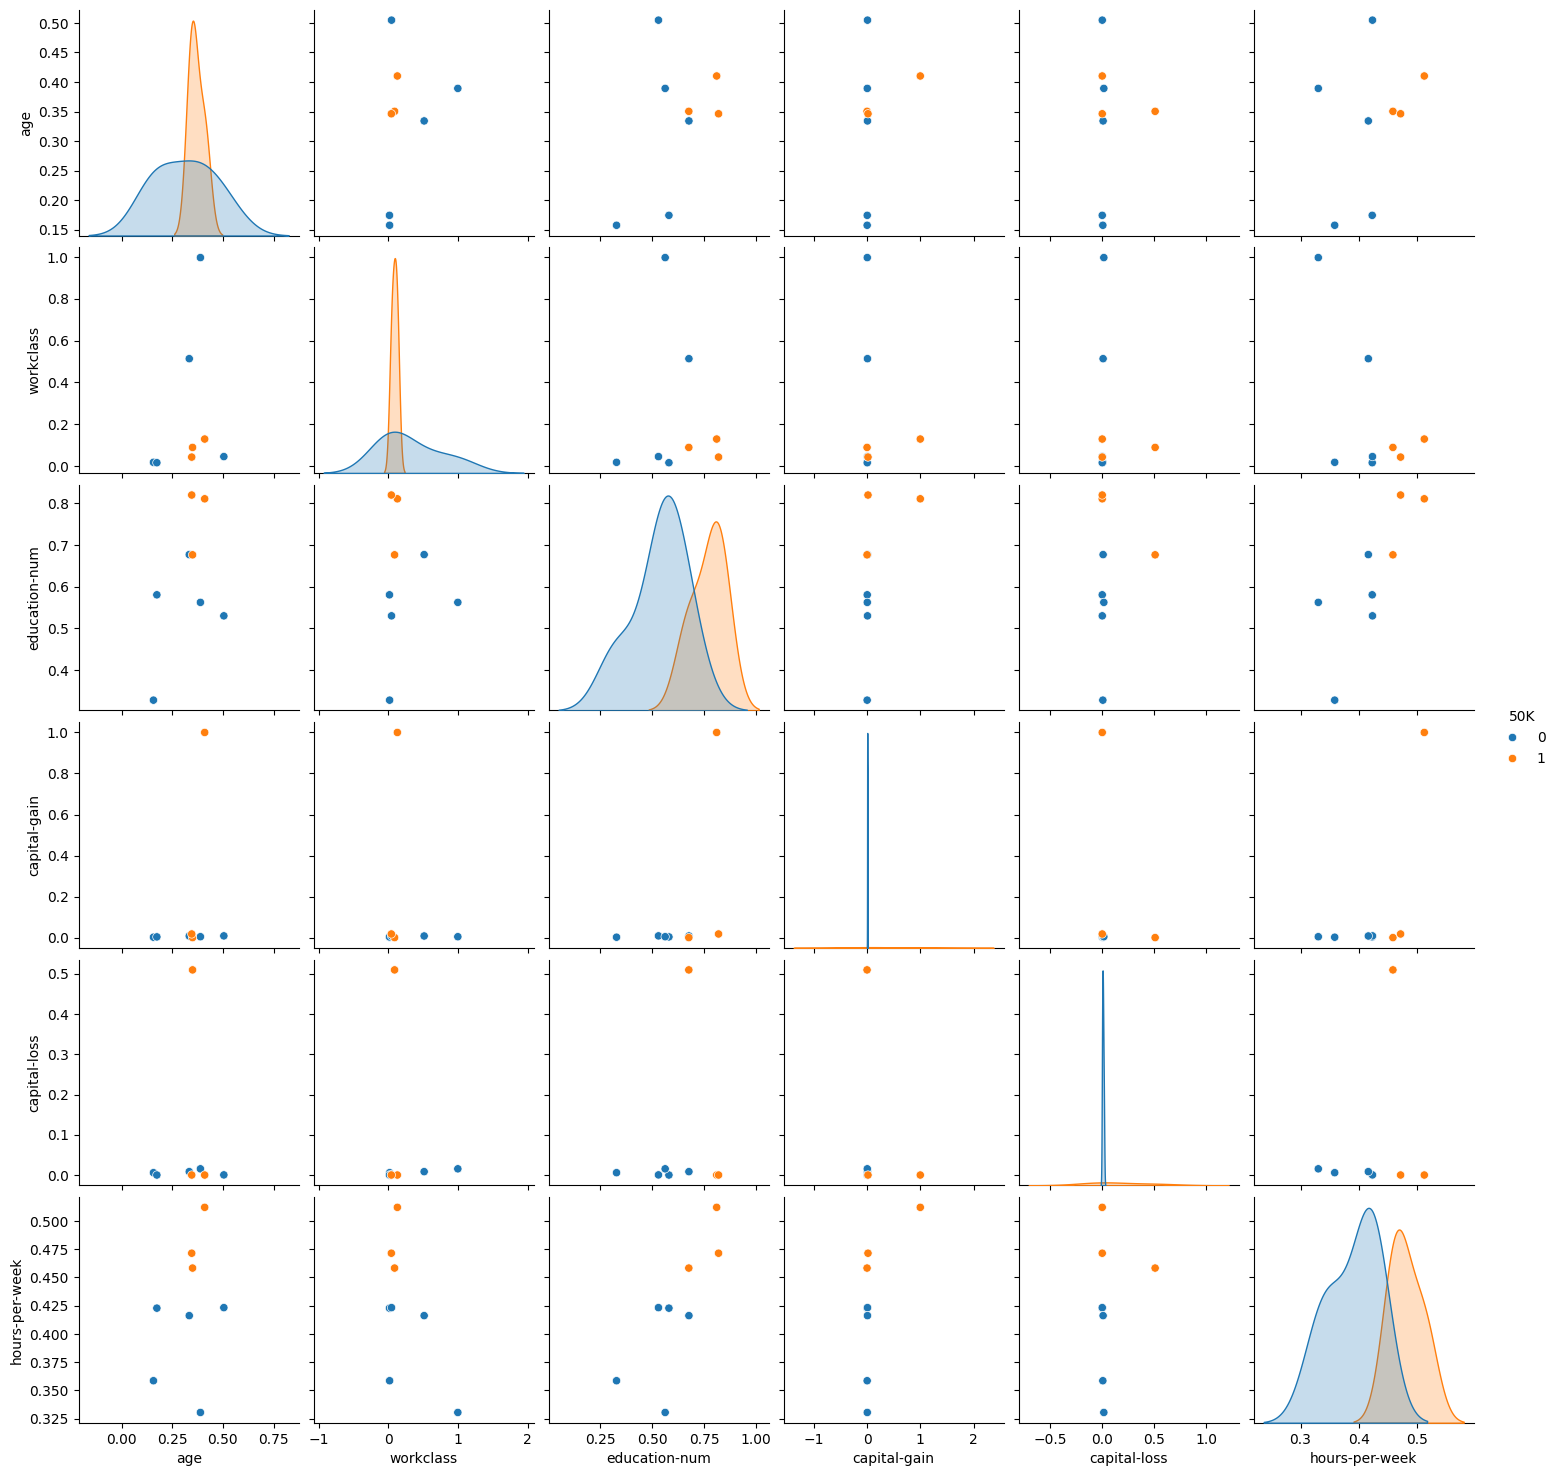

In [12]:
sns.pairplot(df_small, hue="50K")

In [5]:
df.describe()

,age,workclass,education-num,capital-gain,capital-loss,hours-per-week,50K
count,17653.000000,17653.000000,17653.000000,17653.000000,17653.000000,17653.000000,17653.000000
mean,0.312178,0.133901,0.617666,0.014086,0.027814,0.425856,0.325157
std,0.184411,0.256048,0.165146,0.086013,0.116493,0.125438,0.468447
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.164384,0.000000,0.533333,0.000000,0.000000,0.397959,0.000000
50%,0.287671,0.000000,0.600000,0.000000,0.000000,0.397959,0.000000
75%,0.438356,0.125000,0.800000,0.000000,0.000000,0.500000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df_small.describe()

,age,workclass,education-num,capital-gain,capital-loss,hours-per-week,50K
count,64.000000,6.400000e+01,64.000000,6.400000e+01,6.400000e+01,64.000000,64.000000
mean,0.369347,2.682161e-01,0.619712,3.844127e-02,7.318212e-02,0.422815,0.328125
std,0.195635,3.438361e-01,0.181111,1.742601e-01,1.805594e-01,0.141260,0.473242
min,0.011904,6.383782e-16,0.211392,-2.081668e-17,-3.469447e-17,0.106615,0.000000
25%,0.221568,1.281947e-02,0.539218,1.510265e-03,-3.122502e-17,0.388622,0.000000
50%,0.343505,6.681548e-02,0.573485,4.699298e-03,-1.387779e-17,0.418945,0.000000
75%,0.518443,4.993043e-01,0.804448,1.255442e-02,1.200555e-03,0.463523,1.000000
max,0.752202,1.000000e+00,0.935876,1.000000e+00,5.552493e-01,0.898359,1.000000


In [3]:
from algo import recourse


In [9]:
recourse(df_small, source, limit=10000000)

[{(3.245454214930695, 6.091841072781546),
  (2.6779020478789164, 4.603026009148257),
  (3.5796634101317744, 6.558628357057721),
  (2.572232857208051, 5.103029730347315),
  (5.413065887441778, 9.033364535137922),
  (5.213595669726821, 9.04023686892462),
  (4.934807679320876, 6.408449409870012),
  (2.9829192211090874, 6.087852917983937),
  (4.1571306936913786, 7.021089307053527),
  (1.918538850140814, 5.25375092251349),
  (3.159047076364219, 5.231371154864986),
  (3.601799795592005, 7.051078249718398),
  (5.216490341731842, 7.751348634507217),
  (3.1503556214400392, 4.744095538294577),
  (4.95896946000953, 8.234527210667386),
  (3.013542877903646, 6.728272188458464),
  (1.9557602898398248, 4.604239645321747),
  (2.875858273409066, 5.218065877619267),
  (2.0764833134164937, 5.08171033234484),
  (3.2540534594201715, 5.079737815043449),
  (3.9352796188341577, 5.5718077924968),
  (2.7447778975672428, 5.278592878354461),
  (3.957037518797616, 7.555424786358047),
  (2.990856689323507, 6.409523